In [1]:
%pylab inline
import matplotlib as mpl
from pygadgetreader import *
from mpl_toolkits.mplot3d import Axes3D
import soda

Populating the interactive namespace from numpy and matplotlib


In [2]:
font = {'size':16, 'family':'serif'}
matplotlib.rc('font', **font)

In [3]:
# Function that reads the data from the Analytic integration
#Galactocentic distances and velocities
def reading_data(snap_name):
    host = loadtxt('../../../orbits/data/lmc/'+ snap_name +'_host.txt')
    sat = loadtxt('../../../orbits/data/lmc/'+ snap_name +'_sat.txt')
    t = host[:,0] 
    # Defining galactocentric distances and velocities
    x = sat[:,1] - host[:,1] 
    y = sat[:,2] - host[:,2] 
    z = sat[:,3] - host[:,3] 

    vx = sat[:,4] - host[:,4] 
    vy = sat[:,5] - host[:,5] 
    vz = sat[:,6] - host[:,6]        

    Rgal = np.sqrt(x**2.0 + y**2.0 + z**2.0)
    Vgal = np.sqrt(vx**2.0 + vy**2.0 + vz**2.0)
    
    return t, x, y, z, vx, vy, vz, Rgal, Vgal

# Host coordinates and velocities
def data_host(snap_name):
    host = loadtxt('../../../orbits/data/lmc/'+ snap_name +'_host.txt')
    return host[:,1], host[:,2], host[:,3], host[:,4], host[:,5], host[:,6]

# Satellite coordinates and velocities
def data_sat(snap_name):
    sat = loadtxt('../../../orbits/data/lmc/'+ snap_name +'_sat.txt')
    return sat[:,1], sat[:,2], sat[:,3], sat[:,4], sat[:,5], sat[:,6]

#ICs
def ICs(Rgal, cut, x, y, z, vx, vy, vz, t):
    Rcut = np.where(Rgal>=cut)[0]
    return Rgal[Rcut[0]], x[Rcut[0]], y[Rcut[0]], z[Rcut[0]], vx[Rcut[0]], vy[Rcut[0]], vz[Rcut[0]], t[Rcut[0]]

#Function that reads the N-body sumulation orbit
def reading_Nbody(snap_name):
    data = np.loadtxt('orbits/' + snap_name)
    #time = data[:,0]
    #Rgal = data[:,1]
    x_sat= data[:,6]
    y_sat = data[:,7]
    z_sat = data[:,8]
    x_gal = data[:,0]
    y_gal = data[:,1]
    z_gal = data[:,2]
    #Vgal = data[:,8]
    vx_sat = data[:,9]
    vy_sat = data[:,10]
    vz_sat = data[:,11]
    vx_gal = data[:,3]
    vy_gal = data[:,4]
    vz_gal = data[:,5]
    Rgal= np.sqrt((x_sat-x_gal)**2 + (y_sat-y_gal)**2 + (z_sat-z_gal)**2)
    Vgal= np.sqrt((vx_sat-vx_gal)**2 + (vy_sat-vy_gal)**2 + (vz_sat-vz_gal)**2)

    return Rgal, x_sat, y_sat, z_sat, x_gal, y_gal, z_gal, Vgal, vx_sat, vy_sat, vz_sat, vx_gal, vy_gal, vz_gal

def best_values(x, y, z, vx, vy, vz):
    """
    Computes the closes value of the N-body orbit to the observed present day LMC positions
    and velocities.
    
    """
    x_obs = -1
    y_obs = -41
    z_obs = -28
    vx_obs = -57
    vy_obs = -226
    vz_obs = 221
    Robs = np.sqrt((x_obs-x)**2.0 + (y_obs-y)**2.0 + (z_obs-z)**2.0)
    index = np.where(Robs == min(Robs))[0]
    
    sigma_vx = 13
    sigma_vy = 15
    sigma_vz = 19
    
    dx = x_obs - x[index]
    dy = y_obs - y[index]
    dz = z_obs - z[index]
    
    dvx = vx_obs - vx[index]
    dvy = vy_obs - vy[index]
    dvz = vz_obs - vz[index]
    t = np.linspace(0, 3, 151)

    print('Dr = ', dx, dy, dz)
    print('Dv = ', dvx, dvy, dvz)
    
    return t[index], x[index], y[index], z[index], vx[index], vy[index], vz[index]

In [4]:
def analytic_integration(a_soft, pos_sat, vel_sat):
    MW_halo_mass= 1.3E12
    a = 18.54
    M_disk = 5.78E10
    M_bulge = 1.41E10
    CC = 15

    sat_model = ['hernquist', 1E11, 12.7]

    pos_host = np.array([0,0,0])
    vel_host = np.array([0,0,0])
    host_model = ['NFW', MW_halo_mass, 278, CC]
    disk_params = [M_disk, 3.5, 0.68]
    bulge_params = [M_bulge, 0.7]
    alpha = [0, a_soft]
    time = 5.0
    #d_t = [0.1, 0.01, 0.001]
    t_nb, sat_R_nb, sat_V_nb, host_R_nb, host_V_nb = soda.leapfrog.integrate_sat(3, pos_host, vel_host,
                                                                  host_model, disk_params, bulge_params,
                                                                  satellite_model=sat_model,
                                                                  pos_sat=pos_sat, vel_sat=vel_sat,
                                                                  direction=1,
                                                                  dt=0.01,
                                                                  alpha=alpha)
    Rgal= np.sqrt((sat_R_nb[:,0]-host_R_nb[:,0])**2 + (sat_R_nb[:,1]-host_R_nb[:,1])**2 + 
                  (sat_R_nb[:,2]-host_R_nb[:,2])**2)

    gal_posx = sat_R_nb[:,0]-host_R_nb[:,0]
    gal_posy = sat_R_nb[:,1]-host_R_nb[:,1]
    gal_posz = sat_R_nb[:,2]-host_R_nb[:,2]

    gal_velx = sat_V_nb[:,0]-host_V_nb[:,0]
    gal_vely = sat_V_nb[:,1]-host_V_nb[:,1]
    gal_velz = sat_V_nb[:,2]-host_V_nb[:,2]
    
    return t_nb, Rgal, gal_posx, gal_posy, gal_posz, gal_velx, gal_vely, gal_velz

In [5]:
t_an1_06, Ran1_06, posx1_06, posy1_06, posz1_06, velx1_06, vely1_06, velz1_06 = analytic_integration(0.65, [-1, -41, -28],
                                                                                                    [-57, -226, 221])

Host:  0.0 0.0 0.0
Satellite 1 : -1.0 -41.0 -28.0


18.3573699437 261.068262242 90.4794353999
10.7771160192 0.203445030833 -62.4039189092


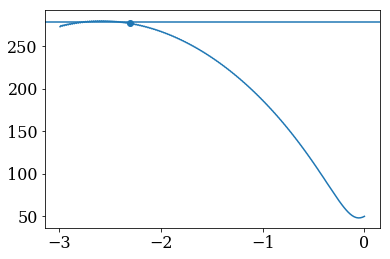

In [6]:
plot(t_an1_06, Ran1_06)
scatter(t_an1_06[-70], Ran1_06[-70])
print(posx1_06[-70], posy1_06[-70], posz1_06[-70])
print(velx1_06[-70], vely1_06[-70], velz1_06[-70])

axhline(278)

In [7]:
t_an1_07, Ran1_07, posx1_07, posy1_07, posz1_07, velx1_07, vely1_07, velz1_07 = analytic_integration(0.7, [-1, -41, -28],
                                                                                                    [-57, -226, 221])

Host:  0.0 0.0 0.0
Satellite 1 : -1.0 -41.0 -28.0


20.6720645735 269.332877423 83.4259186942
9.21774319235 -15.2507126079 -66.8506441137


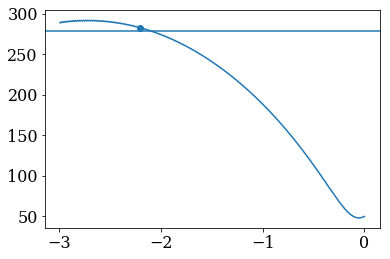

In [8]:
plot(t_an1_07, Ran1_07)
scatter(t_an1_07[-80], Ran1_07[-80])
print(posx1_07[-80], posy1_07[-80], posz1_07[-80])
print(velx1_07[-80], vely1_07[-80], velz1_07[-80])

axhline(278)


In [9]:
t_an1_08, Ran1_08, posx1_08, posy1_08, posz1_08, velx1_08, vely1_08, velz1_08 = analytic_integration(0.8, [-1, -41, -28],
                                                                                                    [-57, -226, 221])

Host:  0.0 0.0 0.0
Satellite 1 : -1.0 -41.0 -28.0


23.8551608033 282.36706546 75.3895608629
6.85814520492 -35.78835839 -71.0930725397


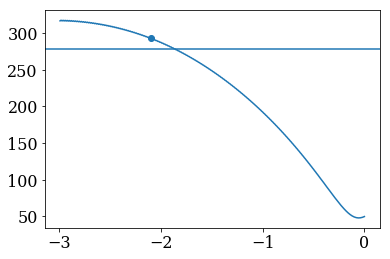

In [10]:
plot(t_an1_08, Ran1_08)
scatter(t_an1_08[-90], Ran1_08[-90])
print(posx1_08[-90], posy1_08[-90], posz1_08[-90])
print(velx1_08[-90], vely1_08[-90], velz1_08[-90])

axhline(278)


In [11]:
t_an1_09, Ran1_09, posx1_09, posy1_09, posz1_09, velx1_09, vely1_09, velz1_09 = analytic_integration(0.92, [-1, -41, -28],
                                                                                                    [-57, -226, 221])

Host:  0.0 0.0 0.0
Satellite 1 : -1.0 -41.0 -28.0


25.3685454902 307.999823746 88.4657138841
6.04282626887 -36.9454356208 -68.8218537826


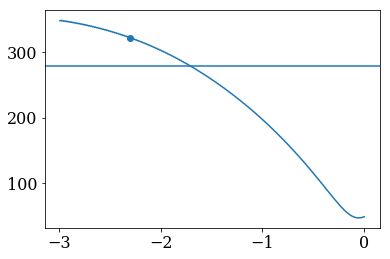

In [12]:
plot(t_an1_09, Ran1_09)
scatter(t_an1_09[-70], Ran1_09[-70])
print(posx1_09[-70], posy1_09[-70], posz1_09[-70])
print(velx1_09[-70], vely1_09[-70], velz1_09[-70])

axhline(278)

In [13]:
RgalNB_065, x_sat, y_sat, z_sat, x_gal, y_gal, z_gal, Vgal, vx_sat, vy_sat, vz_sat, vx_gal,\
vy_gal, vz_gal = reading_Nbody('LMC4/LMC4_1Mb0_orbit_1_065.txt')
best_values(x_sat-x_gal, y_sat-y_gal, z_sat-z_gal, vx_sat-vx_gal, vy_sat-vy_gal, vz_sat-vz_gal)

Dr =  [-0.321277] [-7.01545] [-7.846089]
Dv =  [ 24.753413] [ 55.023039] [-31.07196]


(array([ 2.3]),
 array([-0.678723]),
 array([-33.98455]),
 array([-20.153911]),
 array([-81.753413]),
 array([-281.023039]),
 array([ 252.07196]))

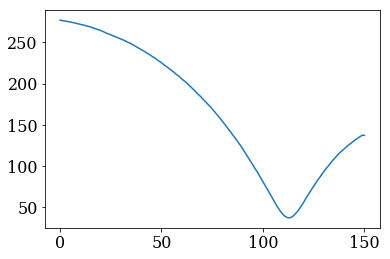

In [14]:
plot(RgalNB_065)

In [15]:
RgalNB_07, x_sat, y_sat, z_sat, x_gal, y_gal, z_gal, Vgal, vx_sat, vy_sat, vz_sat, vx_gal,\
vy_gal, vz_gal = reading_Nbody('LMC4/LMC4_1Mb0_orbit_1_07.txt')
best_values(x_sat-x_gal, y_sat-y_gal, z_sat-z_gal, vx_sat-vx_gal, vy_sat-vy_gal, vz_sat-vz_gal)

Dr =  [-1.168921] [-8.363674] [-5.042807]
Dv =  [ 21.113545] [ 64.58659] [-21.47868]


(array([ 2.18]),
 array([ 0.168921]),
 array([-32.636326]),
 array([-22.957193]),
 array([-78.113545]),
 array([-290.58659]),
 array([ 242.47868]))

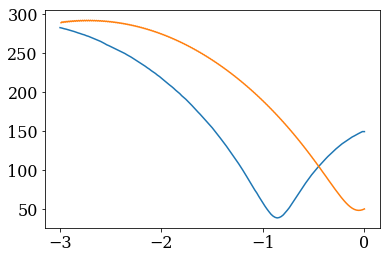

In [16]:
plot(linspace(0, 3, 151)-3, RgalNB_07)
plot(t_an1_07, Ran1_07)


In [17]:
RgalNB_08, x_sat, y_sat, z_sat, x_gal, y_gal, z_gal, Vgal, vx_sat, vy_sat, vz_sat, vx_gal,\
vy_gal, vz_gal = reading_Nbody('LMC4/LMC4_1Mb0_orbit_08.txt')
best_values(x_sat-x_gal, y_sat-y_gal, z_sat-z_gal, vx_sat-vx_gal, vy_sat-vy_gal, vz_sat-vz_gal)

Dr =  [-0.692144] [-4.810501] [-4.145121]
Dv =  [ 26.458482] [ 48.624078] [-17.159988]


(array([ 2.2]),
 array([-0.307856]),
 array([-36.189499]),
 array([-23.854879]),
 array([-83.458482]),
 array([-274.624078]),
 array([ 238.159988]))

In [18]:
RgalNB_09, x_sat, y_sat, z_sat, x_gal, y_gal, z_gal, Vgal, vx_sat, vy_sat, vz_sat, vx_gal,\
vy_gal, vz_gal = reading_Nbody('LMC4/LMC4_1Mb0_orbit_09.txt')
best_values(x_sat-x_gal, y_sat-y_gal, z_sat-z_gal, vx_sat-vx_gal, vy_sat-vy_gal, vz_sat-vz_gal)

Dr =  [-0.110288] [-1.809123] [-4.814274]
Dv =  [ 14.834004] [ 47.44703] [-26.511538]


(array([ 2.32]),
 array([-0.889712]),
 array([-39.190877]),
 array([-23.185726]),
 array([-71.834004]),
 array([-273.44703]),
 array([ 247.511538]))

In [19]:
RgalNB_092, x_sat, y_sat, z_sat, x_gal, y_gal, z_gal, Vgal, vx_sat, vy_sat, vz_sat, vx_gal,\
vy_gal, vz_gal = reading_Nbody('LMC4/LMC4_1Mb0_orbit_092.txt')
best_values(x_sat-x_gal, y_sat-y_gal, z_sat-z_gal, vx_sat-vx_gal, vy_sat-vy_gal, vz_sat-vz_gal)

Dr =  [-0.021999] [-1.508951] [-4.997738]
Dv =  [ 9.0106] [ 44.26081] [-23.86268]


(array([ 2.32]),
 array([-0.978001]),
 array([-39.491049]),
 array([-23.002262]),
 array([-66.0106]),
 array([-270.26081]),
 array([ 244.86268]))

In [20]:
RgalNB_2092, x_sat, y_sat, z_sat, x_gal, y_gal, z_gal, Vgal, vx_sat, vy_sat, vz_sat, vx_gal,\
vy_gal, vz_gal = reading_Nbody('LMC4/LMC4_1Mb0_orbit_2_092.txt')
best_values(x_sat-x_gal, y_sat-y_gal, z_sat-z_gal, vx_sat-vx_gal, vy_sat-vy_gal, vz_sat-vz_gal)

Dr =  [-0.133848] [-1.579271] [-4.682491]
Dv =  [ 11.026272] [ 46.679513] [-25.738725]


(array([ 2.32]),
 array([-0.866152]),
 array([-39.420729]),
 array([-23.317509]),
 array([-68.026272]),
 array([-272.679513]),
 array([ 246.738725]))

In [21]:
RgalNB_3092, x_sat, y_sat, z_sat, x_gal, y_gal, z_gal, Vgal, vx_sat, vy_sat, vz_sat, vx_gal,\
vy_gal, vz_gal = reading_Nbody('LMC4/LMC4_1Mb0_orbit_3_092.txt')
best_values(x_sat-x_gal, y_sat-y_gal, z_sat-z_gal, vx_sat-vx_gal, vy_sat-vy_gal, vz_sat-vz_gal)

Dr =  [-1.143719] [-5.659114] [-2.250573]
Dv =  [ 28.668801] [ 55.798899] [-13.261389]


(array([ 2.28]),
 array([ 0.143719]),
 array([-35.340886]),
 array([-25.749427]),
 array([-85.668801]),
 array([-281.798899]),
 array([ 234.261389]))

In [22]:
RgalNB_4092, x_sat, y_sat, z_sat, x_gal, y_gal, z_gal, Vgal, vx_sat, vy_sat, vz_sat, vx_gal,\
vy_gal, vz_gal = reading_Nbody('LMC4/LMC4_1Mb0_orbit_4_092.txt')
best_values(x_sat-x_gal, y_sat-y_gal, z_sat-z_gal, vx_sat-vx_gal, vy_sat-vy_gal, vz_sat-vz_gal)

Dr =  [-1.154123] [-5.601995] [-2.007403]
Dv =  [ 23.079359] [ 59.29018] [-15.41244]


(array([ 2.28]),
 array([ 0.154123]),
 array([-35.398005]),
 array([-25.992597]),
 array([-80.079359]),
 array([-285.29018]),
 array([ 236.41244]))

In [23]:
RgalNB_5092, x_sat, y_sat, z_sat, x_gal, y_gal, z_gal, Vgal, vx_sat, vy_sat, vz_sat, vx_gal,\
vy_gal, vz_gal = reading_Nbody('LMC4/LMC4_1Mb0_orbit_5_092.txt')
best_values(x_sat-x_gal, y_sat-y_gal, z_sat-z_gal, vx_sat-vx_gal, vy_sat-vy_gal, vz_sat-vz_gal)

Dr =  [ 0.103973] [-1.510017] [-5.248957]
Dv =  [ 13.660049] [ 49.885619] [-26.091741]


(array([ 2.32]),
 array([-1.103973]),
 array([-39.489983]),
 array([-22.751043]),
 array([-70.660049]),
 array([-275.885619]),
 array([ 247.091741]))